In [2]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
from hyperopt import fmin, tpe, Trials, hp, STATUS_OK
from sklearn.model_selection import train_test_split
from sklearn.neural_network import MLPClassifier
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix, ConfusionMatrixDisplay

# config
np.set_printoptions(threshold=np.inf)
np.set_printoptions(formatter={'float_kind':'{:.12f}'.format})

In [3]:
data = pd.read_csv('extracted_features.csv')
x = data[['Mean-accX','Range-accX','Var-accX', 'Median-accX',
          'Mean-accY', 'Range-accY', 'Var-accY', 'Median-accY',
          'Mean-accZ', 'Range-accZ', 'Var-accZ', 'Median-accZ', 
          'Mean-gyroX', 'Range-gyroX', 'Var-gyroX', 'Median-gyroX',
          'Mean-gyroY', 'Range-gyroY', 'Var-gyroY', 'Median-gyroY',
          'Mean-gyroZ', 'Range-gyroZ', 'Var-gyroZ', 'Median-gyroZ',
          ]]
y = data[['label']]
y = y.values.reshape(-1, )
x_train, x_test, y_train, y_test = train_test_split(x, y, test_size=0.3, random_state=42)

In [6]:
baseline_classifier = MLPClassifier(hidden_layer_sizes=(50,),
                                    activation='tanh',)
baseline_classifier.fit(x_train, y_train)
y_baseline_pred = baseline_classifier.predict(x_test)
print("baseline accuracy:" + str(accuracy_score(y_test, y_baseline_pred)))

baseline accuracy:0.85


C:\Users\Yong Han\anaconda3\envs\pythonProject1\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:702: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(


100%|██████████████████████████████████████████████████████████████| 50/50 [00:06<00:00,  8.29trial/s, best loss: -1.0]
Training Accuracy: 1.000000
Testing Accuracy: 1.000000


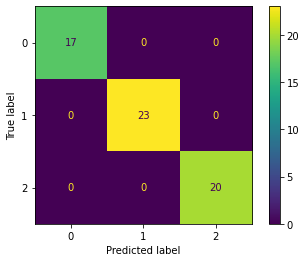

              precision    recall  f1-score   support

           1       1.00      1.00      1.00        17
           2       1.00      1.00      1.00        23
           3       1.00      1.00      1.00        20

    accuracy                           1.00        60
   macro avg       1.00      1.00      1.00        60
weighted avg       1.00      1.00      1.00        60

MLPClassifier(activation='tanh', alpha=0.0007756936253066098,
              hidden_layer_sizes=(50,), learning_rate_init=0.2523437408112441,
              max_iter=2000, solver='sgd')


In [5]:
# # Hyperparameter Optimization
coarse_search_space = \
    {'hidden_layer_size': hp.choice('hidden_layer_sizes', [(5,), (50,), (50,50)]),
     'alpha': hp.lognormal('alpha', mu=np.log(1e-4), sigma=1),
     'solver': hp.choice('algorithm', ['sgd', 'adam']),
     'activation': hp.choice('activation', ['tanh']),
     'learning_rate_init': hp.loguniform('learning_rate_init', low=np.log(1e-4), high=np.log(1.)),
     }


def objective_fn(args):
    dict = {
        'hidden_layer_sizes': args['hidden_layer_size'],
        'alpha': args['alpha'],
        'activation': args['activation'],
        'solver': args['solver'],
        'learning_rate_init': args['learning_rate_init'],
        'max_iter': 2000,
    }
    classifier = MLPClassifier(**dict)
    classifier.fit(x_train, y_train)
    loss = -classifier.score(x_test, y_test)
    return {'loss': loss, 'status': STATUS_OK, 'model': classifier}


trials = Trials()
best = fmin(objective_fn,
            space=coarse_search_space,
            algo=tpe.suggest,
            trials=trials,
            max_evals=50)

best_model = trials.best_trial['result']['model']
print("Training Accuracy: %f" % best_model.score(x_train, y_train))
print("Testing Accuracy: %f" % best_model.score(x_test, y_test))
y_pred = best_model.predict(x_test)
cm = confusion_matrix(y_test, y_pred)
disp = ConfusionMatrixDisplay(confusion_matrix=cm)
disp.plot()
plt.show()
print(classification_report(y_pred, y_test))
print(best_model)

# Get weights
for i in range(len(best_model.coefs_)):
    weights_file = open('weights' + str(i) + '.txt', "w")
    weights_file.write(repr(best_model.coefs_[i]))
    weights_file.close()


# Get bias
for i in range(len(best_model.intercepts_)):
    bias_file = open('bias' + str(i) + '.txt', "w")
    bias_file.write(repr(best_model.intercepts_[i]))
    bias_file.close()